**YOUR NAMES HERE**

Spring 2024

CS 443: Bio-inspired Machine Learning

# Project 4: Spiking Neural Networks

##### Week 1: Spiking Leaky Integrate and Fire Neurons

In this project, we will use a bio-inspired spiking neural network to classify digits from the MNIST dataset. This explores one way in which brains solve supervised learning problems **without** an explicit "supervised learning" process! The approach to learning centers on unsupervised learning rule known as **spike time dependent plasticity (STDP)**. The STDP learning rule exploits correlations *over time* to learn patterns in data. As in prior projects, **competitive interactions** between neurons play an important role in the learning process over time.


### Reminder: AI Policy

To improve the quality of your learning and out of fairness to your hardworking classmates, AI (e.g. ChatGPT, Copilot, etc.) should NOT be used in ANY way on this project and extensions. This includes both written analysis, plotting, and code. I will only grade your work, not an AI's. I will stop grading your project if I notice AI-generated content (in any capacity).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.show()
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 1: Generate a sequence of spikes

This week we will simulate a simple model of real spiking neurons in the brain — the **Leaky Integrator and Fire (LIF) neuron**. The goal is to get some hands-on experience with spiking neurons before transitioning to building a multi-layer network that processes MNIST next week. We will simulate single or small groups of spiking neurons — starting with the a small modification of the LIF neuron we implemented in class, then we will progressively add more useful properties.

Let's start by generating the sequence of spikes that will serve as the input to your LIF neuron.

### 1a. Period spike train

Read the provided function `make_spikes` below then execute the cell. It is the same as the one we used before in class: it generates a 1D sequence of spikes that arrive over time at a fixed rate (**spike train**). This will serve as the input to your LIF neuron.

In [2]:
def make_spikes(num_steps, t_first_spk, spk_every):
    '''Generates a sequence of neural spikes over `num_steps` time steps.
    Throughout this project assume that each time step corresponds
    to 1 msec of "real time" (e.g. 350 time steps corresponds to 350 msec).

    Example: index 0 of the returned sequence array indicates whether or not there
    is an spike input at `t=0 msec`, index 1 indicates whether or not there is an
    spike input at `t=1 msec`, etc.

    Parameters:
    -----------
    num_steps: int. Number of time steps to simulate.
        Corresponds to `num_steps` msec of time (e.g. 1 time step corresponds to
        1 msec).
    t_first_spk: int: Time step on which the first spike occurs.
    spk_every: int: The frequency at which spikes occur in the spike train.

    Returns:
    -----------
    spikes: ndarray of bool. shape=(num_steps,). Time sequence of spikes.
        True at a specific index means a spike occured at that time.
        False at a specific index means a spike did not occur at that time.
        Example: [False, False, True, False] means the 1st spike occured at t=2 msec.

    '''
    spk_times = np.arange(t_first_spk, num_steps, spk_every)
    spikes = np.zeros(num_steps, dtype=bool)
    spikes[spk_times] = 1
    return spikes

#### Test: Make spikes every 10 msec

Call `make_spikes` to generate spikes over the time period 0 msec (*inclusive*) to 350 msec (*exclusive*), have the first spike arrive at `t = 7` msec, and have the spikes arrive every `10` msec. Name the spike train `input_spikes_10`. Run the test code to check whether your spikes arrive at the expected times.

In [3]:
# Your code here. Name your spike train array input_spikes_10
input_spikes_10 = make_spikes(350, 7, 10)

print(f'Your spike train has {len(input_spikes_10)} time steps and it should have 350.')
print(f'Your spike train has spikes at time indices t=\n{np.nonzero(input_spikes_10 == 1)[0]}\nand spikes should appear at t=')
print('''[  7  17  27  37  47  57  67  77  87  97 107 117 127 137 147 157 167 177
 187 197 207 217 227 237 247 257 267 277 287 297 307 417 427 337 347]''')

Your spike train has 350 time steps and it should have 350.
Your spike train has spikes at time indices t=
[  7  17  27  37  47  57  67  77  87  97 107 117 127 137 147 157 167 177
 187 197 207 217 227 237 247 257 267 277 287 297 307 317 327 337 347]
and spikes should appear at t=
[  7  17  27  37  47  57  67  77  87  97 107 117 127 137 147 157 167 177
 187 197 207 217 227 237 247 257 267 277 287 297 307 417 427 337 347]


### 1b. Generate a well-labeled plot of your spike train.

Use `plt.plot` and label your x and y axes appropriately. Make sure you understand what the plot means and check by eye that it is consistent with the test output above.

Text(0, 0.5, 'spike??')

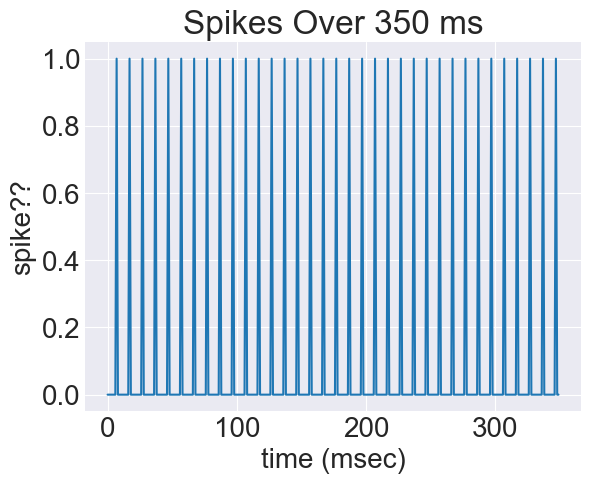

In [4]:
plt.plot(input_spikes_10)
plt.title('Spikes Over 350 ms')
plt.xlabel("time (msec)")
plt.ylabel("spike??")

## Task 2: Implement `LIFNeuron`

The goal of this task is to implement a single LIF neuron (`LIFNeuron` in `lif_neurins.py`). Your `LIFNeuron` should have all the properties of the simple spiking neuron we implemented together in lecture:
- it starts at its **resting voltage** (`v_rest`)
- it integrates the spike train input ("net_in") you generated using `make_spikes`
- it produces a spike when its **membrane potential** (voltage) reaches a critical level (**threshold**) and afterwards has its membrane potential reset to its **reset voltage** (*assumed to be a bit higher than the resetting voltage, but not as high as the spiking threshold*).

There is one new property to add here in `LIFNeuron`: your upgraded LIF neuron will be allowed to enter **refractory periods**: 
- once the neuron spikes, it enters a "disabled state" wherein it is "completely out of commission" for several time steps (for `refrac_count` time steps) during which it cannot integrate inputs. *In neuroscience, this is called hyperpolarization.*
- Only after the cell "sits it out" for its refractory time step count, can it start integrating inputs (i.e. `net_in`) again.

Implement this new version in the `LIFNeuron` class and use the test code below to check your work.

**I recommend looking at and (carefully) copy-pasting parts of the simple neuron from lecture.**



### 2a. Test `initialize_state`

Below, create a `LIFNeuron` object called `test_neuron`, then call the `initialize_state` method. Use default parameters (*you don't need to override*):
- `v_rest`: -65. Neuron's resting voltage (in mV)

In [5]:
from lif_neurons import LIFNeuron

In [6]:
# YOUR CODE HERE
test_neuron = LIFNeuron()
test_neuron.initialize_state()

print(f'Your initial voltage is {test_neuron.v} and should be -65')
print(f'The initial refractory count is 0? {test_neuron.refrac_count == 0}')

Your initial voltage is -65 and should be -65
The initial refractory count is 0? True


### 2b. Test `simulate`

Call the `simulate` method on `test_neuron`. Pass in the spike train that you generated in Task L1a as the `net_in`. Use default parameters:
- `num_steps`: 350. Length of the simulation in msec.
- `v_decay_rate`: 0.99. Rate at which the neuron's voltage decays/decreases in the absence of any input.
- `v_thres`: -60. The voltage threshold (in mV). When the neuron's voltage reaches equals or exceeds this level, the neuron spikes.
- `refrac_len` (**new**): 50. Number of time steps (msec) that the neuron "sits out for" and cannot spike again.


In the cell below, assign the 2 outputs of `simulate` to the variables `spike_rec` and `v_rec`.

**Confusion alert:** Remember that your voltage and spike arrays should have length 351 even though your input array have length 350. This is because the voltage and spike arrays holds the LIF neuron's initial state at time index `t = 0` (*voltage at -65 mV, neuron is not spiking*). The first input affects the entry in the voltage and spike record arrays at index `1` (rather than `0`).

In [7]:
spike_rec, v_rec = test_neuron.simulate(input_spikes_10)

print(f'Your LIF neuron spiked at time indices \nt={np.nonzero(spike_rec == 1)[0]}\n and it should spike at \nt=[ 68 178 288]')
print(f'Your LIF neuron was at resting voltage when \nt={np.nonzero(v_rec == -65)[0]} times and it should be at \nt=[0 1 2 3 4 5 6 7].')
print(f'Your LIF neuron voltage ever get too large? {v_rec.max() > -60.1}')
print(f'Your LIF neuron voltage ever get too small? {v_rec.min() < -65}')

Your LIF neuron spiked at time indices 
t=[ 68 178 288]
 and it should spike at 
t=[ 68 178 288]
Your LIF neuron was at resting voltage when 
t=[0 1 2 3 4 5 6 7] times and it should be at 
t=[0 1 2 3 4 5 6 7].
Your LIF neuron voltage ever get too large? False
Your LIF neuron voltage ever get too small? False


### 2c. Visualize LIF neuron dynamics

Call the function below to visualize the dynamics of your LIF neuron. Make sure that you understand what each of the 3 panels mean.

If your neuron is working as expected, you should see 3 spikes and 3 full "sawtooth" zig-zags in your voltage history.

*After you generate the expected plot, feel free to simulate in a separate cell below the LIF neuron with different parameters to get a better sense of what they do.*

In [8]:
def plot_input_spikes_and_voltage_hist(spike_train_input, spike_hist, v_hist):
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(7, 6))
    axes[0].plot(np.hstack([0, spike_train_input]))
    axes[0].set_ylabel('Input')

    axes[1].plot(spike_hist)
    axes[1].set_ylabel('Spike?')

    axes[2].plot(v_hist)
    axes[2].set_xlabel('Time (msec)')
    axes[2].set_ylabel('Voltage (mV)')
    plt.show()



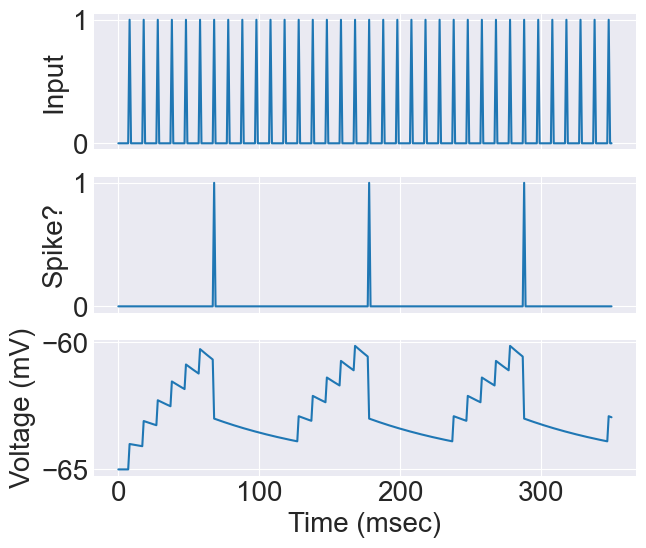

In [9]:
plot_input_spikes_and_voltage_hist(input_spikes_10, spike_rec, v_rec)

## Task 3: JSON parameter configuration files

The number of parameters is going to grow and soon it will be difficult to manage with just function parameters. We will use a JSON file to store and manage the parameter values that specify the configuration in one centralized place. A JSON file is just a text file with a `.json` file extension and it must follow the JSON format.

Here is an example JSON file taken from [here](https://www.freecodecamp.org/news/how-to-use-the-json-module-in-python/):

```json
{
  "data": {
    "date": "Jun 3, 2023",
    "horoscope_data": "The forecast today is stormy. You may have sensed that there was some tension clouding the conversation at home. Resentments were left unsaid and subtle power games were played without resolution. Today, Capricorn, it all becomes too unbearable for you. Regardless of the risks involved, you will take measures to clear things up."
  },
  "status": 200,
  "success": true
}
```


The strings to the left of the `:` are the "keys" and the values on the right are the "values" (just like a Python dictionary). [Read how]([here](https://www.freecodecamp.org/news/how-to-use-the-json-module-in-python/)) the JSON is imported in Python in the "The json.load() function" section.

The nice thing about this is that loading a JSON file into memory from disk produces a Python dictionary. This means we can access parameter values from that one dictionary by name (e.g. `params['v_rest']` to get the value `-65.0`)! It also supports hierarchy so we can group parameters that apply to a common layer together (e.g. `params['input_layer']['v_rest']`) Organized and readable!

### 3a. Test JSON file parsing

Create a JSON file in your project folder called `lif.json`. It should contain the following entries (**NOTE:** the following is NOT valid JSON...you need to format it properly...see above example):

```
Key: "a", value: 1.5
Key: "second_key", value: [5, 10, 15]
Key: "nested", value: The following two key/value pairs:
    Key: "nest_1": 3.14
    Key: "nest_2": 0.001
```

Write test code below that uses the Python `json` module to load `lif.json`. 

Printing your loaded dictionary should result in:

```
{'a': 1.5, 'second_key': [5, 10, 15], 'nested': {'nest_1': 3.14, 'nest_2': 0.001}}
```

Printing `test_params['second_key']` (*adjust naming to reflect your dictionary name*) should return `[5, 10, 15]`

In [10]:
import json
with open("lif.json", "r") as file:
    test_params = json.load(file)

print(test_params)

{'a': 1.5, 'second_key': [5, 10, 15], 'nested': {'nest,_1': 3.14, 'nest_2': 0.001}}


In [11]:
print(test_params['second_key'])

[5, 10, 15]


## Task 4: Layer of spiking LIF neurons

In this task, you will simulate a small network layer of LIF spiking neurons in the class `LIFLayer`.

A primary difference compared to `LIFNeuron` is this version simulates **multiple** neurons in the same layer. **While `LIFLayer` builds on `LIFNeuron`, you will need to add a dimension/axis to some of your arrays to account for the fact that we are simulating multiple neurons (vs. just one in `LIFNeuron`).**

We will gradually add features to the layer of LIF neurons over the course of this task.

In [12]:
from lif_neurons import LIFLayer

### Task 4a. Make LIF layer config file

Make a JSON file (e.g. `lif_layer_params.json`) that stores the following parameter values:

- Number of neurons in the network layer: `2`
- resting voltage of `-65 mV`
- reset voltage of `-63 mV`
- voltage decay rate of `0.99`
- spike voltage threshold of `-60 mV`
- refractory period length of `5` time steps

Load in your JSON parameter file below as a Python dictionary.

In [13]:
with open("lif_layer_params.json", "r") as file:
    test_params_2 = json.load(file)

print(test_params_2)

{'num_neurons': 2, 'v_rest': -65, 'v_reset': -63, 'v_decay_rate': 0.99, 'threshold': -60, 'refrac_period': 5, 'trace_decay_rate': 0.9, 'adaptive_decay_rate': 0.999, 'adaptive_threshold': 0.5}


### Task 4b. Start implementing `LIFLayer` class:

Implement and test the following methods in `spiking_lab.py`:
- Constructor
- `initialize_state`
- `reset_state`
- get methods: `get_v`, `get_spikes`, `get_refrac_count`

Then below, create a `LIFLayer` object called `lifnet`, passing in your parameters, and initialize the layer.

In [14]:
# Create LIFLayer and Initialize it here
lifnet = LIFLayer(test_params_2)
lifnet.initialize_state()

v = lifnet.get_v()
refrac_count = lifnet.get_refrac_count()
print(f'The shape of your voltage array is {v.shape} and should be (2,)')
print(f'Initial voltage set to rest value? {v[0] == -65}')
print(f'Spike container for neuron shape is {lifnet.get_spikes().shape} and should be (2,)')
print(f'The shape of your refractory count array has shape {refrac_count.shape} and it should be (2,)')
print(f'Your refractory counts initialized to default values? {np.all(refrac_count == 0)}')

The shape of your voltage array is (2,) and should be (2,)
Initial voltage set to rest value? True
Spike container for neuron shape is (2,) and should be (2,)
The shape of your refractory count array has shape (2,) and it should be (2,)
Your refractory counts initialized to default values? True


### Task 4c. Implement `net_act`

#### Test: one time step

In [15]:
lifnet.reset_state()

test_input = np.array([True, False])
lifnet.net_act(test_input)

print(f'Neuron voltages are {lifnet.get_v()} and should be [-64. -65.]')
print(f'Current spikes = {lifnet.get_spikes().sum()} and should be 0')
print(f'Refractory counts are {lifnet.get_refrac_count()} and should be [0, 0]')

print('***Resetting the state...***')
lifnet.reset_state()

print(f'Neuron voltages are {lifnet.get_v()} and should be [-65. -65.]')
print(f'Current spikes = {lifnet.get_spikes().sum()} and should be 0')
print(f'Refractory counts are {lifnet.get_refrac_count()} and should be [0, 0]')

Neuron voltages are [-64. -65.] and should be [-64. -65.]
Current spikes = 0 and should be 0
Refractory counts are [0. 0.] and should be [0, 0]
***Resetting the state...***
Neuron voltages are [-65. -65.] and should be [-65. -65.]
Current spikes = 0 and should be 0
Refractory counts are [0. 0.] and should be [0, 0]


#### Test: 7 time steps

In [16]:
lifnet.reset_state()

test_input = np.array([True, False])
# spike at t=5
for t in range(7):
    lifnet.net_act(test_input)

print(f'Neuron voltages are {lifnet.get_v()} and should be [-63.02 -65.  ]')
print(f'Curr spikes = {lifnet.get_spikes().sum()} and should be 0')
print(f'Refractory counts are {lifnet.get_refrac_count()} and should be [4, 0]')

print('***Resetting the state...***')
lifnet.reset_state()

print(f'Neuron voltages are {lifnet.get_v()} and should be [-65. -65.]')
print(f'Curr spikes = {lifnet.get_spikes().sum()} and should be 0')
print(f'Refractory counts are {lifnet.get_refrac_count()} and should be [0, 0]')

Neuron voltages are [-63.02 -65.  ] and should be [-63.02 -65.  ]
Curr spikes = 0 and should be 0
Refractory counts are [4. 0.] and should be [4, 0]
***Resetting the state...***
Neuron voltages are [-65. -65.] and should be [-65. -65.]
Curr spikes = 0 and should be 0
Refractory counts are [0. 0.] and should be [0, 0]


### Task 4d. Implement `simulate`

#### Test: `simulate`

In [17]:
print('7 step simulation:')
test_input = np.array(7*[[False, True]])
spike_rec, _, _= lifnet.simulate(test_input, num_steps=7)

print(f'Total spikes over simulation = {spike_rec.sum()} and should be 1')

print('***Trying another identical simulation...***')
spike_rec, _, _ = lifnet.simulate(test_input, num_steps=7)
print(f'Total spikes over simulation = {spike_rec.sum()} and should be 1')

print('100 step simulation:')
test_input = np.array(100*[[False, True]])
spike_rec, _, _ = lifnet.simulate(test_input, num_steps=100)

print(f'Total spikes over simulation = {spike_rec.sum()} and should be 11')

7 step simulation:
Total spikes over simulation = 1 and should be 1
***Trying another identical simulation...***
Total spikes over simulation = 1 and should be 1
100 step simulation:
Total spikes over simulation = 11 and should be 11


### Task 4e. Add activity traces to `LIFLayer`

Recall that an **activity trace** $T(t)$, a time-varying "memory signal" that indicates how recently the neuron spiked.

$$
T(t) = 
\begin{cases}
    1 & \text{if neuron spikes at time } t \\
    \epsilon_{\text{trace}} T(t-1) & \text{otherwise.}
\end{cases}
$$

where $\epsilon_{\text{trace}}$ represents the trace decay rate (default value: `0.9`) from one time to the next. The default value for the trace (at initialization) is `0` (i.e. $T(0) = 0$). In summary, the decaying "memory trace" defaults to `0`, becomes 1 if the neuron spikes, or otherwise decays (see above equation).

Make the following updates to add support for traces:
1. JSON file (`lif_layer_params.json`): Add entry for a trace decay rate of `0.9`.
2. `initialize_state`: Initialize the trace for each neuron to `0`.
3. `reset_state`: Set every neuron's trace to the default value of `0`.
4. Write the `get_trace` method.
5. `net_act`: Set the trace of every neuron that spikes at the current time step to `1`. Decay the trace every neuron that does not spike at the current time step.
6. `simulate`: Record the trace of each neuron at every time step.

#### Test: Traces

In [18]:
print('7 step simulation:')
test_input = np.array(7*[[False, True]])
spike_rec, trace_rec, _ = lifnet.simulate(test_input, num_steps=7)

print(f'Total spikes over simulation = {spike_rec.sum()} and should be 1')
print(f'Trace for neuron 0: {trace_rec[:, 0]} and should be [0. 0. 0. 0. 0. 0. 0. 0.]')
print(f'Trace for neuron 1: {trace_rec[:, 1]} and should be [0.  0.  0.  0.  0.  0.  1.  0.9]')

print('***Trying another identical simulation...***')
spike_rec, trace_rec, _ = lifnet.simulate(test_input, num_steps=7)

print(f'Total spikes over simulation = {spike_rec.sum()} and should be 1')
print(f'Trace for neuron 0: {trace_rec[:, 0]} and should be [0. 0. 0. 0. 0. 0. 0. 0.]')
print(f'Trace for neuron 1: {trace_rec[:, 1]} and should be [0.  0.  0.  0.  0.  0.  1.  0.9]')

print('100 step simulation:')
test_input = np.array(100*[[False, True]])
spike_rec, trace_rec, _ = lifnet.simulate(test_input, num_steps=100)

print(f'Total spikes over simulation = {spike_rec.sum()} and should be 11')
print(f'Trace values on last 5 time steps for neuron 0: {trace_rec[-5:, 0]} and should be [0. 0. 0. 0. 0.]')
print(f'Trace values on last 5 time steps for neuron 1: {trace_rec[-5:, 1]} and should be [1.    0.9   0.81  0.729 0.656]')

7 step simulation:
Total spikes over simulation = 1 and should be 1
Trace for neuron 0: [0. 0. 0. 0. 0. 0. 0. 0.] and should be [0. 0. 0. 0. 0. 0. 0. 0.]
Trace for neuron 1: [0.  0.  0.  0.  0.  0.  1.  0.9] and should be [0.  0.  0.  0.  0.  0.  1.  0.9]
***Trying another identical simulation...***
Total spikes over simulation = 1 and should be 1
Trace for neuron 0: [0. 0. 0. 0. 0. 0. 0. 0.] and should be [0. 0. 0. 0. 0. 0. 0. 0.]
Trace for neuron 1: [0.  0.  0.  0.  0.  0.  1.  0.9] and should be [0.  0.  0.  0.  0.  0.  1.  0.9]
100 step simulation:
Total spikes over simulation = 11 and should be 11
Trace values on last 5 time steps for neuron 0: [0. 0. 0. 0. 0.] and should be [0. 0. 0. 0. 0.]
Trace values on last 5 time steps for neuron 1: [1.    0.9   0.81  0.729 0.656] and should be [1.    0.9   0.81  0.729 0.656]


### Task 4f. Plot activity trace and spikes

In the cell below, run a simulation of the two neuron `LIFLayer` over `350` msec (time steps) with the spike train from Task L1. Use [np.column_stack](https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack) or a similar NumPy function to send the same spike train input to both neurons.

Use `plt.plot` to make  ONE well-labeled plot showing spikes and the activity trace **of only the first neuron** (index 0) over time produced by your LIF neuron (two curves in one plot, for spikes and trace, in different colors).

Neuron 0 spiked 6 times and should have spiked 6 times.
Neuron 1 spiked 6 times and should have spiked 6 times.
Neuron 0 spiked at
t=[ 68 118 168 218 268 318] and should be
t=[ 68 118 168 218 268 318]
Neuron 1 spiked at
t=[ 68 118 168 218 268 318] and should be
t=[ 68 118 168 218 268 318]


Text(0, 0.5, 'y')

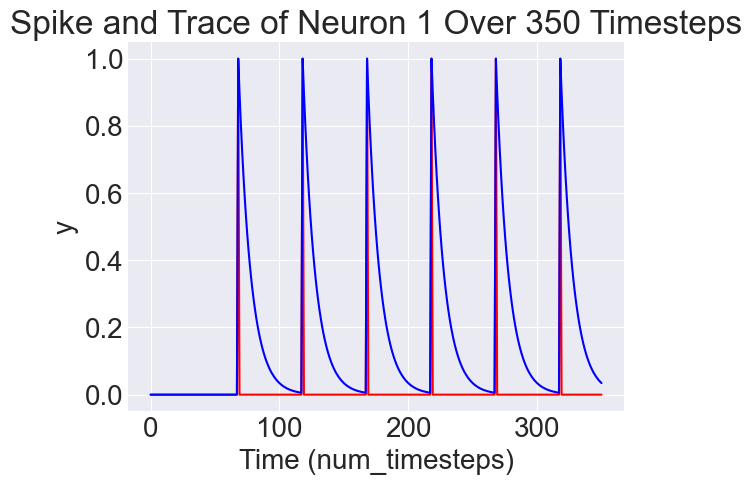

In [19]:


train_2 = np.column_stack((input_spikes_10, input_spikes_10))
lifnet_2 = LIFLayer(test_params_2)
spike_rec, trace_rec, _ = lifnet_2.simulate(train_2)

# Test code for spikes
print(f'Neuron 0 spiked {spike_rec[:, 0].sum()} times and should have spiked 6 times.')
print(f'Neuron 1 spiked {spike_rec[:, 1].sum()} times and should have spiked 6 times.')
print(f'Neuron 0 spiked at\nt={np.argwhere(spike_rec[:, 0] > 0).squeeze()} and should be')
print('t=[ 68 118 168 218 268 318]')
print(f'Neuron 1 spiked at\nt={np.argwhere(spike_rec[:, 1] > 0).squeeze()} and should be')
print('t=[ 68 118 168 218 268 318]')

plt.plot(spike_rec[:,0], c = 'r', label = 'spike')
plt.plot(trace_rec[:,0], c = 'blue', label = 'trace')
plt.title('Spike and Trace of Neuron 1 Over 350 Timesteps')
plt.xlabel('Time (num_timesteps)')
plt.ylabel('y')

### Task 4g. Add adaptive thresholds to `LIFLayer`

An **adaptive threshold** $\theta$, which changes the voltage threshold at which neurons spike based on the neuron's recent spiking history.

$$
v \geq \Gamma + \theta
$$

where $v$ is the neuron's voltage (membrane potential), $\Gamma$ is the neuron's normal firing threshold (`v_thres`) and $\theta$ is the adaptive threshold. Each time the neuron spikes, increment the adaptive threshold (i.e. $\theta$) to make it harder for the neuron to fire next time around. If the neuron does not spike, the decay the adaptive threshold towards 0. The update equation for $\theta$ at time $t$ is: 

$$
\theta(t) = 
\begin{cases}
    \theta(t) + \theta_+ & \text{if neuron spikes at time } t \\
    \epsilon_{\text{adapt}} \theta(t-1) & \text{otherwise.}
\end{cases}
$$

where $\theta_+$ is a constant increment amount (default value: `0.5 mV`), $\epsilon_{\text{adapt}}$ is the adaptive threshold decay rate (default value: `0.999`) from one time to the next. The default value for the adaptive threshold (at initialization) is `0`.

 *This implements a form of neural homeostasis whereby the neural network tries to maintain firing rates that are not too high or too low.*


Make the following updates to add support for adaptive thresholds:
1. JSON file (`lif_layer_params.json`): Add entries for
   1. the adaptive threshold decay rate of `0.999`.
   2. the adaptive threshold increment of `0.5`.
2. `initialize_state`: Initialize the adaptive threshold for each neuron to `0`.
3. `reset_state`: **No change necessary** — we want the adaptive threshold state to persist longer term across samples and not be reset.
4. Write the `get_adaptive_thres` method.
5. `net_act`: Make the following changes:
   1. If `do_thres` is True, we change the requirement for producing a spike: to spike, a neuron's voltage must be at least as large as the voltage threshold PLUS its adaptive threshold (*that starts off as 0*).
   2. If `do_thres` is True, **increment** the adaptive threshold of every neuron that spikes at the current time step by the adaptive threshold increment (from config file). **Decay** the adaptive threshold of every neuron that does not spike at the current time step.
6. `simulate`: Make the following changes:
   1. Pass in the `do_thres` parameter to `net_act`.
   2. Record the threshold value of each neuron at every time step.

#### Load in new parameters from JSON config file

In the cell below:
1. Load parameters updated with those corresponding to the adaptive threshold below.
2. Make a new `LIFLayer` called `lifnet` below with the updated parameters.

In [20]:
with open("lif_layer_params.json", "r") as file:
    test_params_3 = json.load(file)

print(test_params_3)

lifnet = LIFLayer(test_params_3)

{'num_neurons': 2, 'v_rest': -65, 'v_reset': -63, 'v_decay_rate': 0.99, 'threshold': -60, 'refrac_period': 5, 'trace_decay_rate': 0.9, 'adaptive_decay_rate': 0.999, 'adaptive_threshold': 0.5}


#### Test: Adaptive threshold

In [21]:
print('7 step simulation:')
test_input = np.array(7*[[False, True]])
spike_rec, trace_rec, thres_rec = lifnet.simulate(test_input, num_steps=7, do_thres=True)

print(f'Total spikes over simulation = {spike_rec.sum()} and should be 1')
print(f'Trace for neuron 0: {trace_rec[:, 0]} and should be [0. 0. 0. 0. 0. 0. 0. 0.]')
print(f'Trace for neuron 1: {trace_rec[:, 1]} and should be [0.  0.  0.  0.  0.  0.  1.  0.9]')
print(f'Thresholds for neuron 0: {thres_rec[:, 0]} and should be [0. 0. 0. 0. 0. 0. 0. 0.]')
print(f'Thresholds for neuron 1: {thres_rec[:, 1]} and should be [0.    0.    0.    0.    0.    0.    0.5   0.499]')

print('***Trying another identical simulation...***')
spike_rec, trace_rec, thres_rec = lifnet.simulate(test_input, num_steps=7, do_thres=True)

print(f'Total spikes over simulation = {spike_rec.sum()} and should be 1')
print(f'Trace for neuron 0: {trace_rec[:, 0]} and should be [0. 0. 0. 0. 0. 0. 0. 0.]')
print(f'Trace for neuron 1: {trace_rec[:, 1]} and should be [0.  0.  0.  0.  0.  0.  1.  0.9]')
print(f'Thresholds for neuron 0: {thres_rec[:, 0]} and should be [0. 0. 0. 0. 0. 0. 0. 0.]')
print(f'Thresholds for neuron 1: {thres_rec[:, 1]} and should be [0.    0.    0.    0.    0.    0.    0.5   0.499]')

7 step simulation:
Total spikes over simulation = 1 and should be 1
Trace for neuron 0: [0. 0. 0. 0. 0. 0. 0. 0.] and should be [0. 0. 0. 0. 0. 0. 0. 0.]
Trace for neuron 1: [0.  0.  0.  0.  0.  0.  1.  0.9] and should be [0.  0.  0.  0.  0.  0.  1.  0.9]
Thresholds for neuron 0: [0. 0. 0. 0. 0. 0. 0. 0.] and should be [0. 0. 0. 0. 0. 0. 0. 0.]
Thresholds for neuron 1: [0.    0.    0.    0.    0.    0.    0.5   0.499] and should be [0.    0.    0.    0.    0.    0.    0.5   0.499]
***Trying another identical simulation...***
Total spikes over simulation = 1 and should be 1
Trace for neuron 0: [0. 0. 0. 0. 0. 0. 0. 0.] and should be [0. 0. 0. 0. 0. 0. 0. 0.]
Trace for neuron 1: [0.  0.  0.  0.  0.  0.  1.  0.9] and should be [0.  0.  0.  0.  0.  0.  1.  0.9]
Thresholds for neuron 0: [0. 0. 0. 0. 0. 0. 0. 0.] and should be [0. 0. 0. 0. 0. 0. 0. 0.]
Thresholds for neuron 1: [0.    0.    0.    0.    0.    0.    0.5   0.499] and should be [0.    0.    0.    0.    0.    0.    0.5   0.499]


In [22]:
print('100 step simulation:')
test_input = np.array(100*[[False, True]])
spike_rec, trace_rec, thres_rec = lifnet.simulate(test_input, num_steps=100, do_thres=True)

print(f'Total spikes over simulation = {spike_rec.sum()} and should be 9')
print(f'Trace values on last 5 time steps for neuron 0: {trace_rec[-5:, 0]} and should be [0. 0. 0. 0. 0.]')
print(f'Trace values on last 5 time steps for neuron 1: {trace_rec[-5:, 1]} and should be [0.81  0.729 0.656 0.59  0.531]')
print(f'Thresholds for neuron 0: {thres_rec[-5:, 0]} and should be [0. 0. 0. 0. 0.]')
print(f'Thresholds for neuron 1: {thres_rec[-5:, 1]} and should be [4.306 4.301 4.297 4.293 4.289]')

100 step simulation:
Total spikes over simulation = 9 and should be 9
Trace values on last 5 time steps for neuron 0: [0. 0. 0. 0. 0.] and should be [0. 0. 0. 0. 0.]
Trace values on last 5 time steps for neuron 1: [0.81  0.729 0.656 0.59  0.531] and should be [0.81  0.729 0.656 0.59  0.531]
Thresholds for neuron 0: [0. 0. 0. 0. 0.] and should be [0. 0. 0. 0. 0.]
Thresholds for neuron 1: [4.306 4.301 4.297 4.293 4.289] and should be [4.306 4.301 4.297 4.293 4.289]


### Task 4h. Test and plot spiking neuron with adaptive threshold

1. In the cell below, run a simulation of the two neuron `LIFLayer` over `350` msec (time steps) with the spike train from Task L1. Use [np.column_stack](https://numpy.org/doc/stable/reference/generated/numpy.stack.html#numpy.stack) or a similar NumPy function to send the same spike train input to both neurons. **Remember to turn on the adaptive threshold feature on!**
2. Make two separate plots **both for neuron 0: 1) Spikes and 2) Adaptive threshold over the 350 msec**.

If your adaptive threshold is working as expected, you should see a staircase pattern (*with 4 slanted stair steps*) that rise from 0 to a little more than 1.5 over the simulation.

Neuron 1 spiked 4 times and should have spiked 4 times.
Neuron 2 spiked 4 times and should have spiked 4 times.
Neuron 0 spiked at
t=[ 68 128 198 278] and should be
t=[ 68 128 198 278]
Neuron 1 spiked at
t=[ 68 128 198 278] and should be
t=[ 68 128 198 278]
Adaptive threshold for Neuron 1 min/max is 0.0/1.80 and it should be 0.0/1.80
Adaptive threshold for Neuron 2 min/max is 0.0/1.80 and it should be 0.0/1.80


Text(0, 0.5, 'Y')

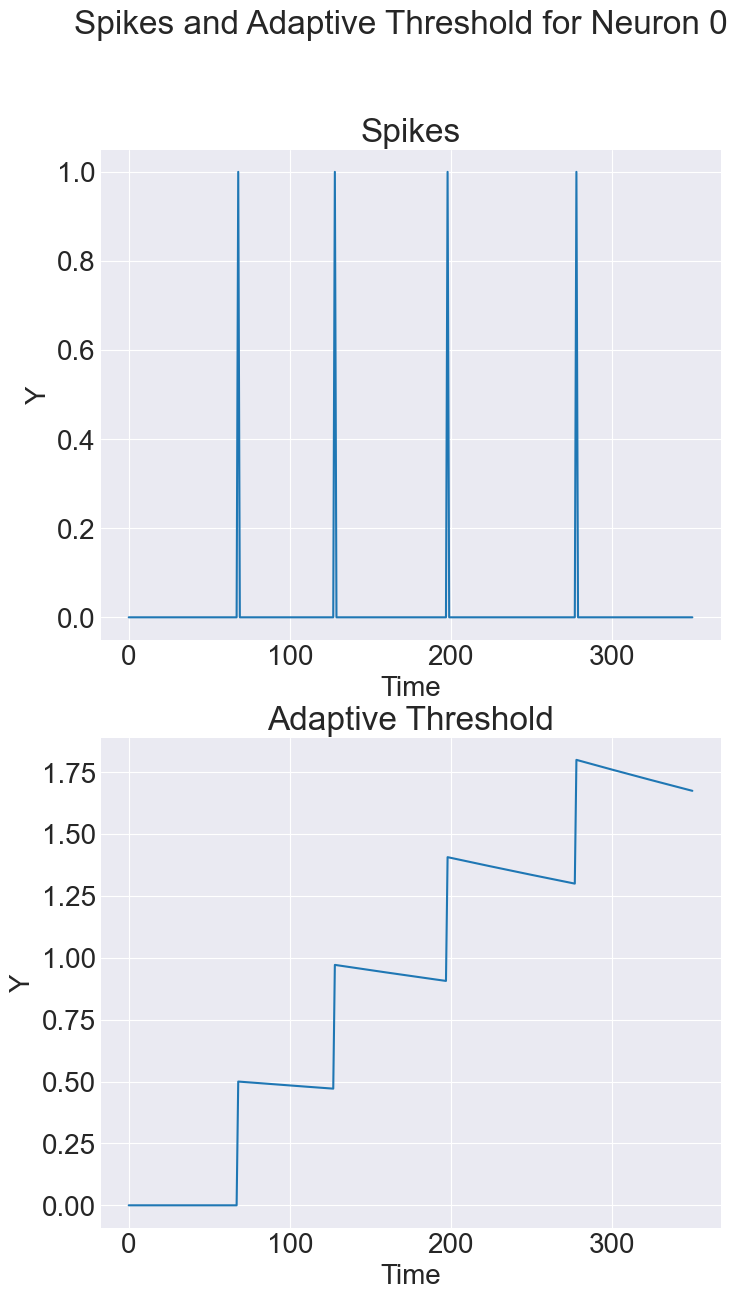

In [23]:

train_2 = np.column_stack((input_spikes_10, input_spikes_10))
lifnet_3 = LIFLayer(test_params_3)
lifnet_3.initialize_state()
spike_rec, trace_rec, thres_rec = lifnet_3.simulate(train_2, do_thres=True)

# TEST CODE
print(f'Neuron 1 spiked {spike_rec[:, 0].sum()} times and should have spiked 4 times.')
print(f'Neuron 2 spiked {spike_rec[:, 1].sum()} times and should have spiked 4 times.')
print(f'Neuron 0 spiked at\nt={np.argwhere(spike_rec[:, 0] > 0).squeeze()} and should be')
print('t=[ 68 128 198 278]')
print(f'Neuron 1 spiked at\nt={np.argwhere(spike_rec[:, 1] > 0).squeeze()} and should be')
print('t=[ 68 128 198 278]')
print(f'Adaptive threshold for Neuron 1 min/max is {thres_rec[:,0].min()}/{thres_rec[:,0].max():.2f} and it should be 0.0/1.80')
print(f'Adaptive threshold for Neuron 2 min/max is {thres_rec[:,1].min()}/{thres_rec[:,1].max():.2f} and it should be 0.0/1.80')

fig, (ax1, ax2) = plt.subplots(2, figsize = (8,14))
fig.suptitle('Spikes and Adaptive Threshold for Neuron 0')
ax1.set_title("Spikes")
ax1.set_xlabel('Time')
ax1.set_ylabel('Y')
ax1.plot(spike_rec[:,0])
ax2.set_title('Adaptive Threshold')
ax2.plot(thres_rec[:,0])
ax2.set_xlabel('Time')
ax2.set_ylabel('Y')

### Task 4i. Questions

**Question 1:** How does the adaptive threshold values relate to the relative spacing between spikes in time?

**Answer 1:** The adaptive threshold can increase more if spikes are closer together since they will not experience as much decay before they are incremented again.  Similarly, if spikes are further apart, the increment of the threshold less significant because the threshold has decayed through the extra time. 

### Task 4j. Check prior test code is working

Restart your kernel and re-execute all cells above. Make sure your trace and/or adaptive thresholds do not break/conflict with `LIFLayer` functionality when these features are turned off.

### Task 4k. Add winner-take-all dynamics

Learning will be more stable in the network when only one neuron is allowed to spike at a time (i.e. winner-take-all dynamics). Modify your `net_act` code to implement the following rule (only if `do_wta` is True):
1. If multiple neurons spikes at any time step, randomly allow **only one of them** to actually spike. This means the spike record should only show **at most** one neuron spiking at any given time.
2. Out of the neurons that could spike at the current time step (*i.e. whether they end up being the winner or not*), you should:
   1. set their voltages to `v_rest`
   2. have them enter their refractory period (just like before)
3. Only the winning neuron that **actually spikes** should have their trace set to 1 and adaptive threshold incremented.
4. **All** non-winner neurons should have their traces and adaptive thresholds decayed for the current time step.
5. In `simulate` pass along the value of `do_wta` to `net_act`.

#### Test: one winner at a time

TEST 2

In [24]:
print('7 step simulation:')
test_input = np.array(7*[[True, True]])
np.random.seed(1)
spike_rec, trace_rec, thres_rec = lifnet.simulate(test_input, num_steps=7, do_thres=True, do_wta=True)

print(f'Total spikes over simulation = {spike_rec.sum()} and should be 1')
print(f'Trace for neuron 0: {trace_rec[:, 0]} and should be [0. 0. 0. 0. 0. 0. 0. 0.]')
print(f'Trace for neuron 1: {trace_rec[:, 1]} and should be [0.  0.  0.  0.  0.  0.  1.  0.9]')
print(f'Thresholds for neuron 0: {thres_rec[:, 0]} and should be [0. 0. 0. 0. 0. 0. 0. 0.] ')
print(f'Thresholds for neuron 1: {thres_rec[:, 1]} and should be [0.    0.    0.    0.    0.    0.    0.5   0.499]')

print('***Trying another identical simulation...***')
np.random.seed(1)
spike_rec, trace_rec, thres_rec = lifnet.simulate(test_input, num_steps=7, do_thres=True, do_wta=True)

print(f'Total spikes over simulation = {spike_rec.sum()} and should be 1')
print(f'Trace for neuron 0: {trace_rec[:, 0]} and should be [0. 0. 0. 0. 0. 0. 0. 0.]')
print(f'Trace for neuron 1: {trace_rec[:, 1]} and should be [0.  0.  0.  0.  0.  0.  1.  0.9]')
print(f'Thresholds for neuron 0: {thres_rec[:, 0]} and should be [0. 0. 0. 0. 0. 0. 0. 0.] ')
print(f'Thresholds for neuron 1: {thres_rec[:, 1]} and should be [0.    0.    0.    0.    0.    0.    0.5   0.499]')

7 step simulation:
Total spikes over simulation = 1 and should be 1
Trace for neuron 0: [0. 0. 0. 0. 0. 0. 0. 0.] and should be [0. 0. 0. 0. 0. 0. 0. 0.]
Trace for neuron 1: [0.  0.  0.  0.  0.  0.  1.  0.9] and should be [0.  0.  0.  0.  0.  0.  1.  0.9]
Thresholds for neuron 0: [0. 0. 0. 0. 0. 0. 0. 0.] and should be [0. 0. 0. 0. 0. 0. 0. 0.] 
Thresholds for neuron 1: [0.    0.    0.    0.    0.    0.    0.5   0.499] and should be [0.    0.    0.    0.    0.    0.    0.5   0.499]
***Trying another identical simulation...***
Total spikes over simulation = 1 and should be 1
Trace for neuron 0: [0. 0. 0. 0. 0. 0. 0. 0.] and should be [0. 0. 0. 0. 0. 0. 0. 0.]
Trace for neuron 1: [0.  0.  0.  0.  0.  0.  1.  0.9] and should be [0.  0.  0.  0.  0.  0.  1.  0.9]
Thresholds for neuron 0: [0. 0. 0. 0. 0. 0. 0. 0.] and should be [0. 0. 0. 0. 0. 0. 0. 0.] 
Thresholds for neuron 1: [0.    0.    0.    0.    0.    0.    0.5   0.499] and should be [0.    0.    0.    0.    0.    0.    0.5   0.499]


In [25]:
print('100 step simulation:')
test_input = np.array(100*[[True, True]])
np.random.seed(1)
spike_rec, trace_rec, thres_rec = lifnet.simulate(test_input, num_steps=100, do_thres=True, do_wta=True)

print(f'Total spikes over simulation = {spike_rec.sum()} and should be 17')
print(f'Trace values on last 5 time steps for neuron 0: {trace_rec[-5:, 0]} and should be [0.387 0.349 0.314 1.    0.9  ]')
print(f'Trace values on last 5 time steps for neuron 1: {trace_rec[-5:, 1]} and should be [0.81  0.729 0.656 0.59  0.531]')
print(f'Thresholds for neuron 0: {thres_rec[-5:, 0]} and should be [3.367 3.364 3.36  3.86  3.857]')
print(f'Thresholds for neuron 1: {thres_rec[-5:, 1]} and should be [4.306 4.301 4.297 4.293 4.289]')

100 step simulation:
Total spikes over simulation = 17 and should be 17
Trace values on last 5 time steps for neuron 0: [0.387 0.349 0.314 1.    0.9  ] and should be [0.387 0.349 0.314 1.    0.9  ]
Trace values on last 5 time steps for neuron 1: [0.81  0.729 0.656 0.59  0.531] and should be [0.81  0.729 0.656 0.59  0.531]
Thresholds for neuron 0: [3.367 3.364 3.36  3.86  3.857] and should be [3.367 3.364 3.36  3.86  3.857]
Thresholds for neuron 1: [4.306 4.301 4.297 4.293 4.289] and should be [4.306 4.301 4.297 4.293 4.289]


### Task 4l. Plot spikes and adaptive threshold

Copy-paste your code from above in which you create the plots showing spikes and adaptive threshold. For the plot below:
1. Remember to turn on the winner-take-all feature before running the simulation.
2. Plot the spikes and adaptive thresholds of both neurons in each plot (2 curves in each of the 2 plots) instead of showing just the first neuron.

Text(0, 0.5, 'Y')

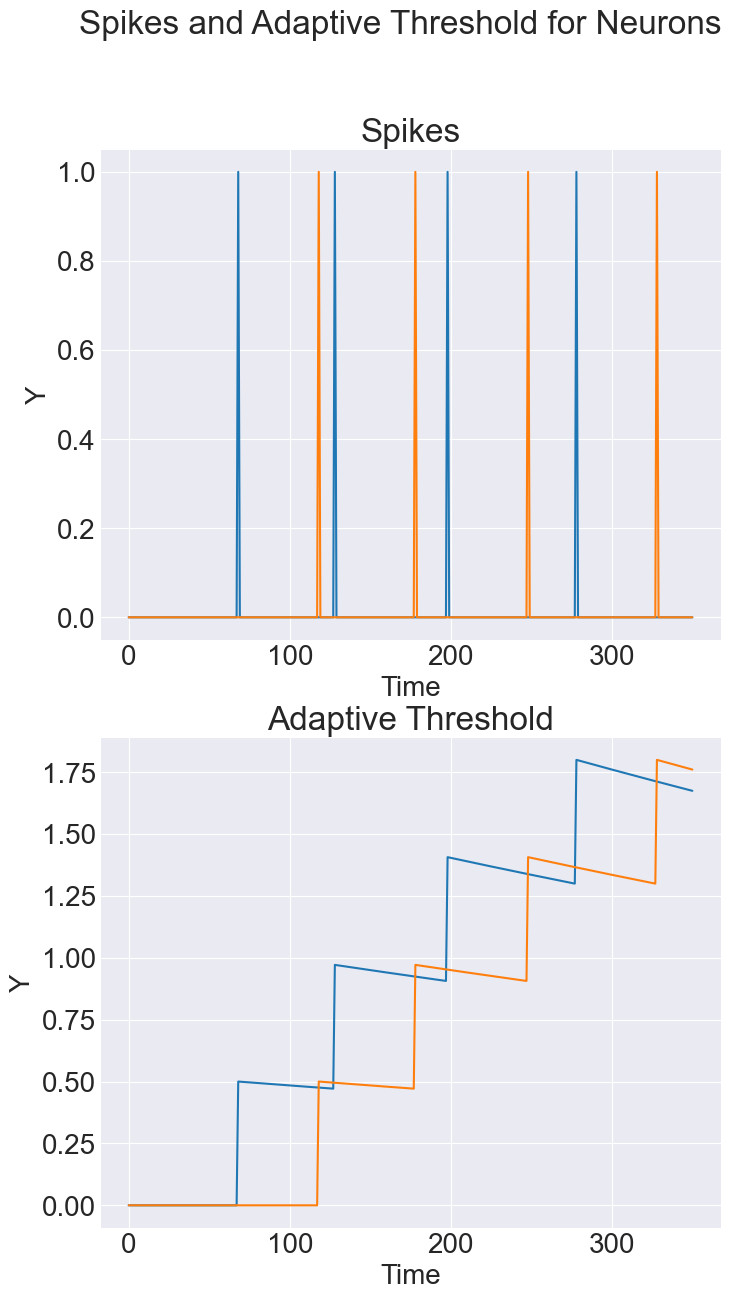

In [27]:
train_2 = np.column_stack((input_spikes_10, input_spikes_10))
lifnet_3 = LIFLayer(test_params_3)
lifnet_3.initialize_state()
spike_rec, trace_rec, thres_rec = lifnet_3.simulate(train_2, do_thres=True, do_wta=True)

fig, (ax1, ax2) = plt.subplots(2, figsize = (8,14))
fig.suptitle('Spikes and Adaptive Threshold for Neurons')
ax1.set_title("Spikes")
ax1.set_xlabel('Time')
ax1.set_ylabel('Y')
ax1.plot(spike_rec[:,0])
ax1.plot(spike_rec[:,1])
ax2.set_title('Adaptive Threshold')
ax2.plot(thres_rec[:,0])
ax2.plot(thres_rec[:,1])
ax2.set_xlabel('Time')
ax2.set_ylabel('Y')

### Task 4m. Questions

**Question 2:** Why are the spikes generated by each neuron staggered now?

**Answer 2:** 

### Task 4n. Check prior test code is working

Restart your kernel and re-execute all cells above. Make sure your winner-take-all does not break/conflict with `LIFLayer` functionality when these features are turned off.